# Local Setup Instructions

## Prerequisites Checklist

- [ ] **Conda environment `fraud-shield` created and activated**
  - Create: `conda env create -f environment.yml`
  - Activate: `conda activate fraud-shield`
- [ ] **Preprocessed data available**
  - Run `02-local-preprocessing.ipynb` first

## Environment Activation

```bash
conda activate fraud-shield
```

# Transformer Models for Fraud Detection

**Notebook:** 06-local-transformers.ipynb
**Objective:** Develop transformer-based models for tabular fraud detection using the 30-feature leak-free dataset.

## Architecture Overview

1. **FT-Transformer**: Feature Tokenizer + Transformer encoder for tabular data
2. **Self-Attention MLP**: Lightweight attention-based architecture

## Key Features

- Learned feature embeddings for each of the 30 input features
- Multi-head self-attention for feature interactions
- Focal loss for class imbalance
- Proper threshold tuning on validation set

In [1]:
# ============================================================
# GLOBAL IMPORTS & DEPENDENCIES
# ============================================================

import os
import sys
from pathlib import Path
from typing import Tuple, List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import joblib
from datetime import datetime
from tqdm.auto import tqdm
import math

print("All dependencies loaded successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All dependencies loaded successfully
PyTorch version: 2.11.0.dev20260206+cu128
CUDA available: True


In [2]:
# ============================================================
# CONFIGURATION & PATHS
# ============================================================

NOTEBOOK_DIR = Path.cwd()
if NOTEBOOK_DIR.name == "local_notebooks":
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    PROJECT_ROOT = NOTEBOOK_DIR

os.chdir(PROJECT_ROOT)

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

PREPROCESSED_TRAIN_PATH = PROCESSED_DATA_DIR / 'train_preprocessed.parquet'
PREPROCESSED_VAL_PATH = PROCESSED_DATA_DIR / 'val_preprocessed.parquet'
PREPROCESSED_TEST_PATH = PROCESSED_DATA_DIR / 'test_preprocessed.parquet'
FEATURE_NAMES_PATH = MODELS_DIR / 'feature_names.pkl'

# ============================================================
# DEVICE CONFIGURATION
# ============================================================
# Set USE_CUDA = True to use GPU, False to force CPU
USE_CUDA = True  # User flag: change to False to force CPU

if USE_CUDA and torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Compute capability: {torch.cuda.get_device_capability(0)}")
else:
    DEVICE = torch.device("cpu")
    if USE_CUDA:
        print("CUDA requested but not available, using CPU")
    else:
        print("Using CPU (user preference)")

print(f"\nProject root: {PROJECT_ROOT}")
print(f"Device: {DEVICE}")

Using GPU: NVIDIA GeForce RTX 5070 Ti
CUDA version: 12.8
Compute capability: (12, 0)

Project root: /home/alireza/Desktop/projects/fraud-shield-ai
Device: cuda


## 1. Load and Prepare Data

In [3]:
# ============================================================
# DATA LOADING
# ============================================================

def load_preprocessed_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Load preprocessed train, validation, and test datasets."""
    if not PREPROCESSED_TRAIN_PATH.exists():
        raise FileNotFoundError(
            f"Preprocessed data not found: {PREPROCESSED_TRAIN_PATH}\n"
            "Please run the preprocessing notebook (02-local-preprocessing.ipynb) first."
        )
    
    print("Loading preprocessed data...")
    train_df = pd.read_parquet(PREPROCESSED_TRAIN_PATH)
    val_df = pd.read_parquet(PREPROCESSED_VAL_PATH)
    test_df = pd.read_parquet(PREPROCESSED_TEST_PATH)
    
    if FEATURE_NAMES_PATH.exists():
        with open(FEATURE_NAMES_PATH, 'rb') as f:
            feature_names = pickle.load(f)
        feature_cols = [col for col in train_df.columns if col != 'is_fraud']
        n = min(len(feature_cols), len(feature_names))
        rename_map = {str(i): feature_names[i] for i in range(n)}
        for df in (train_df, val_df, test_df):
            df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)
    
    print(f"Train: {train_df.shape[0]:,} samples, Fraud rate: {train_df['is_fraud'].mean():.4%}")
    print(f"Val: {val_df.shape[0]:,} samples, Fraud rate: {val_df['is_fraud'].mean():.4%}")
    print(f"Test: {test_df.shape[0]:,} samples, Fraud rate: {test_df['is_fraud'].mean():.4%}")
    
    return train_df, val_df, test_df

train_df, val_df, test_df = load_preprocessed_data()
feature_cols = [col for col in train_df.columns if col != 'is_fraud']
print(f"\nFeatures ({len(feature_cols)}): {feature_cols}")

Loading preprocessed data...
Train: 1,034,987 samples, Fraud rate: 0.5757%
Val: 122,480 samples, Fraud rate: 0.5250%
Test: 555,719 samples, Fraud rate: 0.3860%

Features (30): ['transaction_count_bin', 'card_age_bin', 'hour', 'time_bin', 'is_peak_fraud_hour', 'is_new_card', 'is_low_volume_card', 'category', 'day_of_week', 'month', 'is_peak_fraud_day', 'is_peak_fraud_season', 'is_high_risk_category', 'card_age_days', 'transaction_count', 'evening_high_amount', 'evening_online_shopping', 'large_city_evening', 'new_card_evening', 'high_amount_online', 'temporal_risk_score', 'geographic_risk_score', 'card_risk_score', 'risk_tier', 'amt', 'city_pop', 'customer_merchant_distance_km', 'txn_count_last_1h', 'txn_count_last_24h', 'amt_relative_to_avg']


In [4]:
# ============================================================
# PREPARE TENSORS
# ============================================================

def prepare_tensors(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    feature_cols: List[str]
) -> Tuple[torch.Tensor, ...]:
    """Prepare PyTorch tensors from DataFrames."""
    
    X_train = train_df[feature_cols].values.astype(np.float32)
    y_train = train_df['is_fraud'].values.astype(np.float32)
    X_val = val_df[feature_cols].values.astype(np.float32)
    y_val = val_df['is_fraud'].values.astype(np.float32)
    X_test = test_df[feature_cols].values.astype(np.float32)
    y_test = test_df['is_fraud'].values.astype(np.float32)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32)
    
    return X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t, scaler

X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t, scaler = prepare_tensors(
    train_df, val_df, test_df, feature_cols
)

n_features = X_train_t.shape[1]
print(f"Training samples: {len(X_train_t):,}")
print(f"Validation samples: {len(X_val_t):,}")
print(f"Test samples: {len(X_test_t):,}")
print(f"Number of features: {n_features}")

Training samples: 1,034,987
Validation samples: 122,480
Test samples: 555,719
Number of features: 30


## 2. Transformer Architecture Components

In [5]:
# ============================================================
# FOCAL LOSS
# ============================================================

class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance."""
    
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        p = torch.sigmoid(inputs)
        p_t = p * targets + (1 - p) * (1 - targets)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        loss = -alpha_t * focal_weight * torch.log(p_t + 1e-8)
        return loss.mean()

print("FocalLoss defined.")

FocalLoss defined.


In [6]:
# ============================================================
# TRANSFORMER BUILDING BLOCKS
# ============================================================

class FeatureEmbedding(nn.Module):
    """
    Embed each feature into a higher-dimensional space.
    Each feature gets its own embedding projection.
    """
    
    def __init__(self, n_features: int, embed_dim: int):
        super().__init__()
        self.n_features = n_features
        self.embed_dim = embed_dim
        
        # Each feature has its own linear projection
        self.embeddings = nn.ModuleList([
            nn.Linear(1, embed_dim) for _ in range(n_features)
        ])
        
        # Learnable position embeddings (one per feature)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_features, embed_dim) * 0.02)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (batch, n_features)
        batch_size = x.shape[0]
        
        # Embed each feature separately
        embedded = torch.stack([
            self.embeddings[i](x[:, i:i+1]) 
            for i in range(self.n_features)
        ], dim=1)  # (batch, n_features, embed_dim)
        
        # Add position embeddings
        embedded = embedded + self.pos_embedding
        
        return embedded


class MultiHeadSelfAttention(nn.Module):
    """Multi-head self-attention for feature interaction."""
    
    def __init__(self, embed_dim: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert embed_dim % n_heads == 0, "embed_dim must be divisible by n_heads"
        
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, 3 * embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape
        
        # Compute Q, K, V
        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch, heads, seq, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        # Output
        out = (attn @ v).transpose(1, 2).reshape(batch_size, seq_len, self.embed_dim)
        out = self.proj(out)
        out = self.dropout(out)
        
        return out


class TransformerBlock(nn.Module):
    """Transformer block with pre-norm architecture."""
    
    def __init__(self, embed_dim: int, n_heads: int, ff_dim: int, dropout: float = 0.1):
        super().__init__()
        
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, n_heads, dropout)
        
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

print("Transformer building blocks defined.")

Transformer building blocks defined.


In [7]:
# ============================================================
# FT-TRANSFORMER (Feature Tokenizer Transformer)
# ============================================================

class FTTransformer(nn.Module):
    """
    FT-Transformer for tabular data.
    
    Architecture:
    1. Feature Embedding: Each feature projected to embed_dim
    2. [CLS] Token: Aggregates information across features
    3. Transformer Encoder: Self-attention between features
    4. Classification Head: MLP on [CLS] token
    """
    
    def __init__(
        self,
        n_features: int,
        embed_dim: int = 64,
        n_heads: int = 4,
        n_layers: int = 3,
        ff_dim: int = 256,
        dropout: float = 0.2
    ):
        super().__init__()
        
        self.embed_dim = embed_dim
        
        # Feature embedding
        self.feature_embedding = FeatureEmbedding(n_features, embed_dim)
        
        # [CLS] token for aggregation
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        
        # Transformer encoder
        self.transformer = nn.Sequential(*[
            TransformerBlock(embed_dim, n_heads, ff_dim, dropout)
            for _ in range(n_layers)
        ])
        
        # Final norm
        self.norm = nn.LayerNorm(embed_dim)
        
        # Classification head
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 1)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        
        # Embed features
        x = self.feature_embedding(x)  # (batch, n_features, embed_dim)
        
        # Prepend [CLS] token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # (batch, n_features+1, embed_dim)
        
        # Transformer
        x = self.transformer(x)
        x = self.norm(x)
        
        # Use [CLS] token for classification
        cls_output = x[:, 0]  # (batch, embed_dim)
        
        return self.head(cls_output).squeeze(-1)

print("FT-Transformer defined.")

FT-Transformer defined.


In [8]:
# ============================================================
# SELF-ATTENTION MLP (Lightweight Alternative)
# ============================================================

class SelfAttentionMLP(nn.Module):
    """
    Lightweight attention-based model for tabular data.
    Uses self-attention to learn feature importance before MLP.
    """
    
    def __init__(
        self,
        n_features: int,
        embed_dim: int = 32,
        n_heads: int = 4,
        hidden_dims: List[int] = [128, 64],
        dropout: float = 0.3
    ):
        super().__init__()
        
        # Feature embedding
        self.feature_embedding = FeatureEmbedding(n_features, embed_dim)
        
        # Single attention layer
        self.attention = MultiHeadSelfAttention(embed_dim, n_heads, dropout)
        self.norm = nn.LayerNorm(embed_dim)
        
        # Flatten and MLP
        mlp_input_dim = n_features * embed_dim
        
        layers = []
        prev_dim = mlp_input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.GELU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1))
        
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Embed features
        x = self.feature_embedding(x)  # (batch, n_features, embed_dim)
        
        # Self-attention
        x = x + self.attention(self.norm(x))
        
        # Flatten and MLP
        x = x.flatten(1)  # (batch, n_features * embed_dim)
        return self.mlp(x).squeeze(-1)

print("Self-Attention MLP defined.")

Self-Attention MLP defined.


## 3. Training Infrastructure

In [9]:
# ============================================================
# TRAINING UTILITIES
# ============================================================

def find_best_threshold(y_true: np.ndarray, y_pred_proba: np.ndarray) -> Tuple[float, float]:
    """Find threshold that maximizes F1 score."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    thresholds = np.append(thresholds, 1.0)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    idx = np.nanargmax(f1_scores)
    return float(thresholds[idx]), float(f1_scores[idx])


def evaluate_predictions(
    y_true: np.ndarray,
    y_pred_proba: np.ndarray,
    threshold: float = 0.5,
    dataset_name: str = "Dataset"
) -> Dict[str, float]:
    """Evaluate model predictions at given threshold."""
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    metrics = {
        'f1_score': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'pr_auc': average_precision_score(y_true, y_pred_proba)
    }
    
    print(f"\n{dataset_name} Performance (threshold={threshold:.4f}):")
    print(f"  F1-Score: {metrics['f1_score']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"  PR-AUC: {metrics['pr_auc']:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    print(f"  Confusion: TN={tn:,} FP={fp:,} FN={fn:,} TP={tp:,}")
    print(f"  False Positive Rate: {fpr:.4%}")
    
    return metrics


class EarlyStopping:
    """Early stopping callback."""
    
    def __init__(self, patience: int = 10, min_delta: float = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
    
    def __call__(self, score: float, model: nn.Module) -> bool:
        if self.best_score is None:
            self.best_score = score
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0
        return self.early_stop

print("Training utilities defined.")

Training utilities defined.


In [10]:
# ============================================================
# MAIN TRAINING FUNCTION
# ============================================================

def train_model(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    loss_fn: nn.Module,
    n_epochs: int = 100,
    batch_size: int = 1024,
    lr: float = 1e-4,
    weight_decay: float = 1e-4,
    patience: int = 15,
    warmup_epochs: int = 5
) -> Tuple[nn.Module, Dict[str, List[float]]]:
    """
    Train transformer model with warmup and early stopping.
    """
    model = model.to(DEVICE)
    
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size * 2, shuffle=False)
    
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Warmup + cosine annealing
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        return 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (n_epochs - warmup_epochs)))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    early_stopping = EarlyStopping(patience=patience)
    history = {'train_loss': [], 'val_loss': [], 'val_pr_auc': [], 'val_f1': []}
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        train_losses = []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_losses.append(loss.item())
        
        scheduler.step()
        
        # Validation
        model.eval()
        val_losses = []
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                outputs = model(X_batch)
                loss = loss_fn(outputs, y_batch)
                
                val_losses.append(loss.item())
                val_preds.append(torch.sigmoid(outputs).cpu().numpy())
                val_targets.append(y_batch.cpu().numpy())
        
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        
        val_pr_auc = average_precision_score(val_targets, val_preds)
        best_thresh, val_f1 = find_best_threshold(val_targets, val_preds)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_pr_auc'].append(val_pr_auc)
        history['val_f1'].append(val_f1)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:3d} | LR: {current_lr:.2e} | Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val PR-AUC: {val_pr_auc:.4f} | Val F1: {val_f1:.4f}")
        
        if early_stopping(val_pr_auc, model):
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if early_stopping.best_state is not None:
        model.load_state_dict(early_stopping.best_state)
    
    return model, history

print("Training function defined.")

Training function defined.


## 4. Train FT-Transformer

In [11]:
# ============================================================
# TRAIN FT-TRANSFORMER
# ============================================================

print("="*80)
print("Training FT-Transformer")
print("="*80)

ft_transformer = FTTransformer(
    n_features=n_features,
    embed_dim=64,
    n_heads=4,
    n_layers=3,
    ff_dim=256,
    dropout=0.2
)

focal_loss_ft = FocalLoss(alpha=0.75, gamma=2.0)

ft_transformer, ft_history = train_model(
    model=ft_transformer,
    X_train=X_train_t,
    y_train=y_train_t,
    X_val=X_val_t,
    y_val=y_val_t,
    loss_fn=focal_loss_ft,
    n_epochs=100,
    batch_size=1024,
    lr=1e-4,
    patience=20,
    warmup_epochs=5
)

Training FT-Transformer


Epoch   1 | LR: 2.00e-05 | Train Loss: 0.0426 | Val Loss: 0.0360 | Val PR-AUC: 0.0127 | Val F1: 0.0465


Epoch  10 | LR: 9.93e-05 | Train Loss: 0.0017 | Val Loss: 0.0014 | Val PR-AUC: 0.8105 | Val F1: 0.7642


Epoch  20 | LR: 9.40e-05 | Train Loss: 0.0013 | Val Loss: 0.0011 | Val PR-AUC: 0.8335 | Val F1: 0.7768


Epoch  30 | LR: 8.39e-05 | Train Loss: 0.0012 | Val Loss: 0.0010 | Val PR-AUC: 0.8588 | Val F1: 0.7938


Epoch  40 | LR: 7.01e-05 | Train Loss: 0.0011 | Val Loss: 0.0010 | Val PR-AUC: 0.8638 | Val F1: 0.7966


Epoch  50 | LR: 5.41e-05 | Train Loss: 0.0010 | Val Loss: 0.0009 | Val PR-AUC: 0.8749 | Val F1: 0.8119


Epoch  60 | LR: 3.77e-05 | Train Loss: 0.0010 | Val Loss: 0.0009 | Val PR-AUC: 0.8820 | Val F1: 0.8188


Epoch  70 | LR: 2.27e-05 | Train Loss: 0.0009 | Val Loss: 0.0008 | Val PR-AUC: 0.8863 | Val F1: 0.8235


Epoch  80 | LR: 1.05e-05 | Train Loss: 0.0009 | Val Loss: 0.0009 | Val PR-AUC: 0.8873 | Val F1: 0.8234


Epoch  90 | LR: 2.71e-06 | Train Loss: 0.0009 | Val Loss: 0.0009 | Val PR-AUC: 0.8876 | Val F1: 0.8248


Epoch 100 | LR: 0.00e+00 | Train Loss: 0.0009 | Val Loss: 0.0009 | Val PR-AUC: 0.8875 | Val F1: 0.8244


In [12]:
# ============================================================
# EVALUATE FT-TRANSFORMER
# ============================================================

def get_predictions(model: nn.Module, X: torch.Tensor) -> np.ndarray:
    """Get probability predictions from model."""
    model.eval()
    model = model.to(DEVICE)
    
    with torch.no_grad():
        X = X.to(DEVICE)
        # Process in batches to avoid OOM
        batch_size = 2048
        preds = []
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size]
            logits = model(batch)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds.append(probs)
    return np.concatenate(preds)

y_train_pred_ft = get_predictions(ft_transformer, X_train_t)
y_val_pred_ft = get_predictions(ft_transformer, X_val_t)
y_test_pred_ft = get_predictions(ft_transformer, X_test_t)

best_threshold_ft, best_val_f1_ft = find_best_threshold(y_val_t.numpy(), y_val_pred_ft)
print(f"\nOptimal threshold (max val F1): {best_threshold_ft:.4f}")

print("\n" + "="*80)
print("FT-Transformer - Evaluation at Optimal Threshold")
print("="*80)

train_metrics_ft = evaluate_predictions(y_train_t.numpy(), y_train_pred_ft, best_threshold_ft, "Train")
val_metrics_ft = evaluate_predictions(y_val_t.numpy(), y_val_pred_ft, best_threshold_ft, "Validation")
test_metrics_ft = evaluate_predictions(y_test_t.numpy(), y_test_pred_ft, best_threshold_ft, "Test")


Optimal threshold (max val F1): 0.6096

FT-Transformer - Evaluation at Optimal Threshold



Train Performance (threshold=0.6096):
  F1-Score: 0.8414
  Precision: 0.9051
  Recall: 0.7860
  ROC-AUC: 0.9982
  PR-AUC: 0.9091


  Confusion: TN=1,028,538 FP=491 FN=1,275 TP=4,683
  False Positive Rate: 0.0477%

Validation Performance (threshold=0.6096):
  F1-Score: 0.8258
  Precision: 0.8371
  Recall: 0.8149
  ROC-AUC: 0.9981
  PR-AUC: 0.8880
  Confusion: TN=121,735 FP=102 FN=119 TP=524
  False Positive Rate: 0.0837%



Test Performance (threshold=0.6096):
  F1-Score: 0.5465
  Precision: 0.4750
  Recall: 0.6434
  ROC-AUC: 0.9889
  PR-AUC: 0.6372


  Confusion: TN=552,049 FP=1,525 FN=765 TP=1,380
  False Positive Rate: 0.2755%


## 5. Train Self-Attention MLP

In [13]:
# ============================================================
# TRAIN SELF-ATTENTION MLP
# ============================================================

print("="*80)
print("Training Self-Attention MLP")
print("="*80)

sa_mlp = SelfAttentionMLP(
    n_features=n_features,
    embed_dim=32,
    n_heads=4,
    hidden_dims=[256, 128],
    dropout=0.3
)

focal_loss_sa = FocalLoss(alpha=0.75, gamma=2.0)

sa_mlp, sa_history = train_model(
    model=sa_mlp,
    X_train=X_train_t,
    y_train=y_train_t,
    X_val=X_val_t,
    y_val=y_val_t,
    loss_fn=focal_loss_sa,
    n_epochs=100,
    batch_size=2048,
    lr=5e-4,
    patience=20,
    warmup_epochs=3
)

Training Self-Attention MLP


Epoch   1 | LR: 1.67e-04 | Train Loss: 0.0538 | Val Loss: 0.0457 | Val PR-AUC: 0.1097 | Val F1: 0.3119


Epoch  10 | LR: 4.94e-04 | Train Loss: 0.0014 | Val Loss: 0.0012 | Val PR-AUC: 0.8394 | Val F1: 0.7867


Epoch  20 | LR: 4.63e-04 | Train Loss: 0.0012 | Val Loss: 0.0011 | Val PR-AUC: 0.8531 | Val F1: 0.8029


Epoch  30 | LR: 4.10e-04 | Train Loss: 0.0010 | Val Loss: 0.0009 | Val PR-AUC: 0.8754 | Val F1: 0.8261


Epoch  40 | LR: 3.41e-04 | Train Loss: 0.0009 | Val Loss: 0.0010 | Val PR-AUC: 0.8704 | Val F1: 0.8138


Epoch  50 | LR: 2.62e-04 | Train Loss: 0.0008 | Val Loss: 0.0010 | Val PR-AUC: 0.8730 | Val F1: 0.8271


Early stopping at epoch 51


In [14]:
# ============================================================
# EVALUATE SELF-ATTENTION MLP
# ============================================================

y_train_pred_sa = get_predictions(sa_mlp, X_train_t)
y_val_pred_sa = get_predictions(sa_mlp, X_val_t)
y_test_pred_sa = get_predictions(sa_mlp, X_test_t)

best_threshold_sa, best_val_f1_sa = find_best_threshold(y_val_t.numpy(), y_val_pred_sa)
print(f"\nOptimal threshold (max val F1): {best_threshold_sa:.4f}")

print("\n" + "="*80)
print("Self-Attention MLP - Evaluation at Optimal Threshold")
print("="*80)

train_metrics_sa = evaluate_predictions(y_train_t.numpy(), y_train_pred_sa, best_threshold_sa, "Train")
val_metrics_sa = evaluate_predictions(y_val_t.numpy(), y_val_pred_sa, best_threshold_sa, "Validation")
test_metrics_sa = evaluate_predictions(y_test_t.numpy(), y_test_pred_sa, best_threshold_sa, "Test")


Optimal threshold (max val F1): 0.6004

Self-Attention MLP - Evaluation at Optimal Threshold



Train Performance (threshold=0.6004):
  F1-Score: 0.8406
  Precision: 0.8987
  Recall: 0.7895
  ROC-AUC: 0.9982
  PR-AUC: 0.9073


  Confusion: TN=1,028,499 FP=530 FN=1,254 TP=4,704
  False Positive Rate: 0.0515%

Validation Performance (threshold=0.6004):
  F1-Score: 0.8264
  Precision: 0.8818
  Recall: 0.7776
  ROC-AUC: 0.9966
  PR-AUC: 0.8792
  Confusion: TN=121,770 FP=67 FN=143 TP=500
  False Positive Rate: 0.0550%



Test Performance (threshold=0.6004):
  F1-Score: 0.2871
  Precision: 0.1828
  Recall: 0.6695
  ROC-AUC: 0.9705
  PR-AUC: 0.4860


  Confusion: TN=547,153 FP=6,421 FN=709 TP=1,436
  False Positive Rate: 1.1599%


## 6. Model Comparison

In [15]:
# ============================================================
# MODEL COMPARISON
# ============================================================

comparison_data = {
    'Model': ['FT-Transformer', 'Self-Attention MLP'],
    'Threshold': [best_threshold_ft, best_threshold_sa],
    'Val F1': [val_metrics_ft['f1_score'], val_metrics_sa['f1_score']],
    'Val PR-AUC': [val_metrics_ft['pr_auc'], val_metrics_sa['pr_auc']],
    'Val ROC-AUC': [val_metrics_ft['roc_auc'], val_metrics_sa['roc_auc']],
    'Test F1': [test_metrics_ft['f1_score'], test_metrics_sa['f1_score']],
    'Test PR-AUC': [test_metrics_ft['pr_auc'], test_metrics_sa['pr_auc']],
    'Test ROC-AUC': [test_metrics_ft['roc_auc'], test_metrics_sa['roc_auc']],
    'Test Precision': [test_metrics_ft['precision'], test_metrics_sa['precision']],
    'Test Recall': [test_metrics_ft['recall'], test_metrics_sa['recall']]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("TRANSFORMER MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

best_idx = comparison_df['Test F1'].idxmax()
print(f"\nBest Model: {comparison_df.loc[best_idx, 'Model']}")
print(f"  Test F1: {comparison_df.loc[best_idx, 'Test F1']:.4f}")
print(f"  Test PR-AUC: {comparison_df.loc[best_idx, 'Test PR-AUC']:.4f}")


TRANSFORMER MODEL COMPARISON
             Model  Threshold   Val F1  Val PR-AUC  Val ROC-AUC  Test F1  Test PR-AUC  Test ROC-AUC  Test Precision  Test Recall
    FT-Transformer   0.609584 0.825847    0.887981     0.998064 0.546535     0.637192      0.988856        0.475043     0.643357
Self-Attention MLP   0.600401 0.826446    0.879227     0.996604 0.287143     0.486018      0.970457        0.182767     0.669464

Best Model: FT-Transformer
  Test F1: 0.5465
  Test PR-AUC: 0.6372


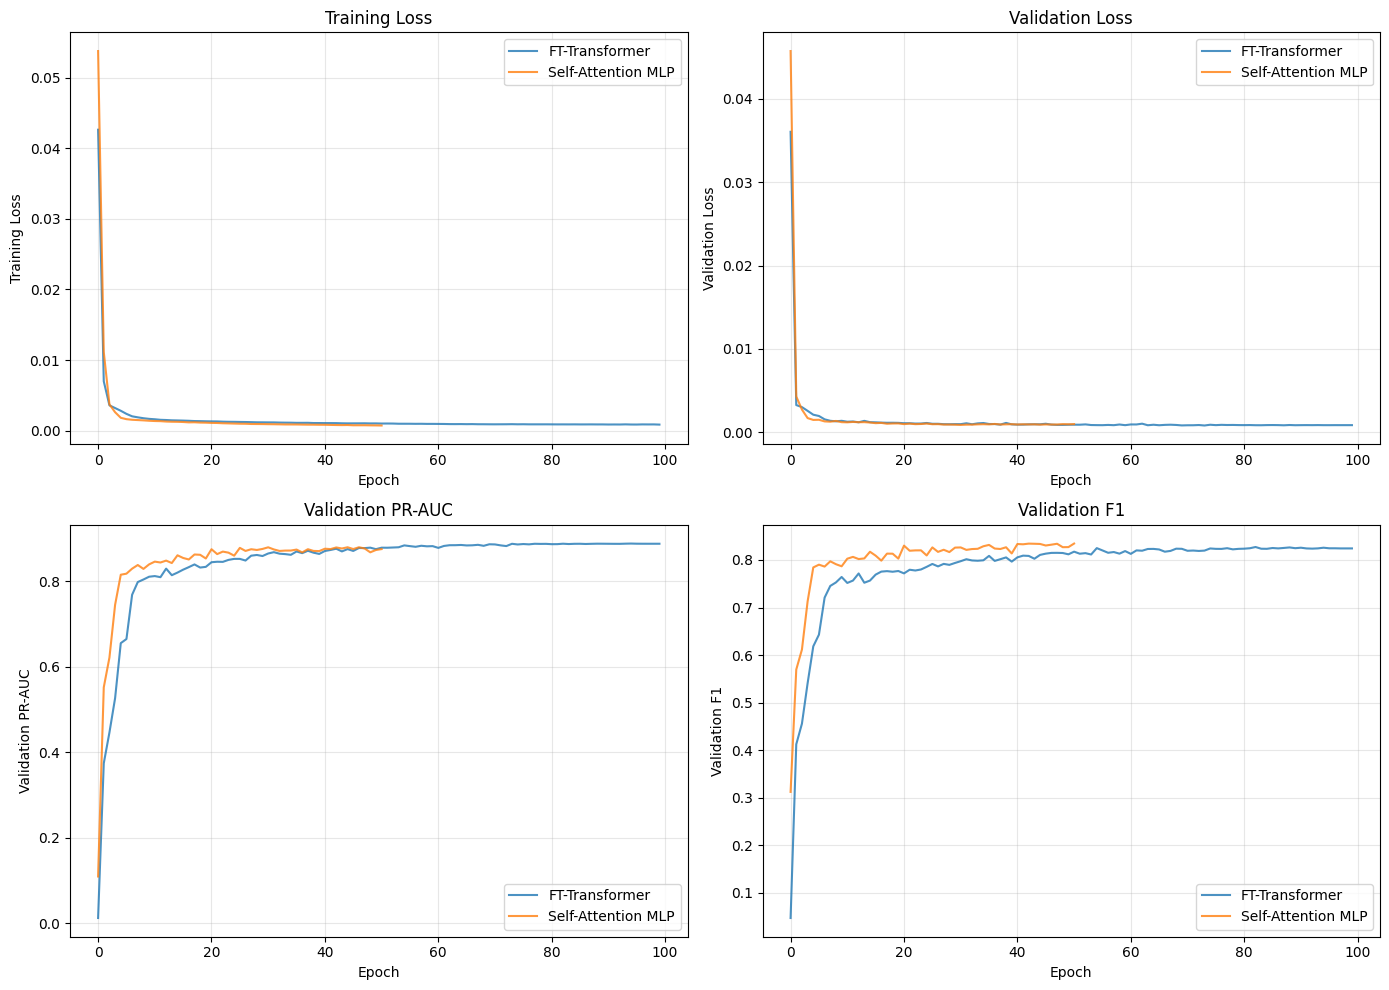

In [16]:
# ============================================================
# PLOT TRAINING CURVES
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(ft_history['train_loss'], label='FT-Transformer', alpha=0.8)
axes[0, 0].plot(sa_history['train_loss'], label='Self-Attention MLP', alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Training Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(ft_history['val_loss'], label='FT-Transformer', alpha=0.8)
axes[0, 1].plot(sa_history['val_loss'], label='Self-Attention MLP', alpha=0.8)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation Loss')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(ft_history['val_pr_auc'], label='FT-Transformer', alpha=0.8)
axes[1, 0].plot(sa_history['val_pr_auc'], label='Self-Attention MLP', alpha=0.8)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Validation PR-AUC')
axes[1, 0].set_title('Validation PR-AUC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(ft_history['val_f1'], label='FT-Transformer', alpha=0.8)
axes[1, 1].plot(sa_history['val_f1'], label='Self-Attention MLP', alpha=0.8)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation F1')
axes[1, 1].set_title('Validation F1')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'transformer_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

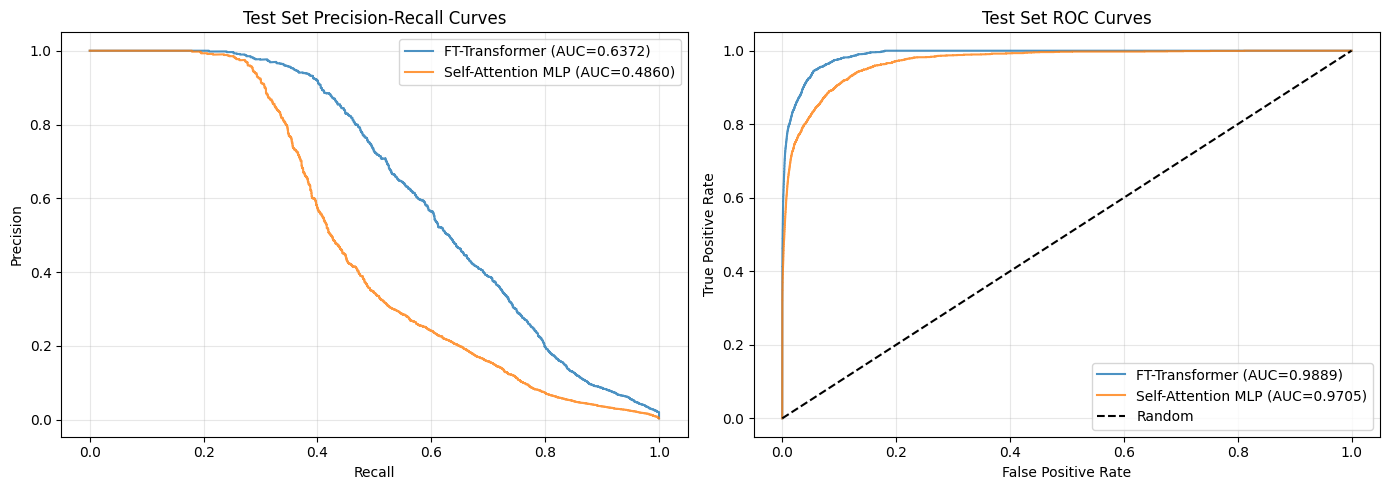

In [17]:
# ============================================================
# PLOT PR AND ROC CURVES
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PR Curves
for name, preds in [('FT-Transformer', y_test_pred_ft), ('Self-Attention MLP', y_test_pred_sa)]:
    precision, recall, _ = precision_recall_curve(y_test_t.numpy(), preds)
    pr_auc = average_precision_score(y_test_t.numpy(), preds)
    axes[0].plot(recall, precision, label=f'{name} (AUC={pr_auc:.4f})', alpha=0.8)

axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Test Set Precision-Recall Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ROC Curves
for name, preds in [('FT-Transformer', y_test_pred_ft), ('Self-Attention MLP', y_test_pred_sa)]:
    fpr, tpr, _ = roc_curve(y_test_t.numpy(), preds)
    roc_auc = roc_auc_score(y_test_t.numpy(), preds)
    axes[1].plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.4f})', alpha=0.8)

axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Test Set ROC Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'transformer_pr_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Save Best Model

In [18]:
# ============================================================
# SAVE BEST MODEL
# ============================================================

models_dict = {
    'FT-Transformer': (ft_transformer, best_threshold_ft, test_metrics_ft),
    'Self-Attention MLP': (sa_mlp, best_threshold_sa, test_metrics_sa)
}

best_model_name = comparison_df.loc[best_idx, 'Model']
best_model, best_threshold, best_metrics = models_dict[best_model_name]

model_path = MODELS_DIR / 'transformer_best_model.pt'
torch.save({
    'model_state_dict': best_model.state_dict(),
    'model_class': best_model.__class__.__name__,
    'n_features': n_features,
    'threshold': best_threshold,
    'metrics': best_metrics,
    'feature_cols': feature_cols
}, model_path)

print(f"Best model saved: {model_path}")

scaler_path = MODELS_DIR / 'transformer_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved: {scaler_path}")

comparison_df.to_csv(RESULTS_DIR / 'transformer_comparison.csv', index=False)
print(f"Comparison saved: {RESULTS_DIR / 'transformer_comparison.csv'}")

Best model saved: /home/alireza/Desktop/projects/fraud-shield-ai/models/transformer_best_model.pt
Scaler saved: /home/alireza/Desktop/projects/fraud-shield-ai/models/transformer_scaler.pkl
Comparison saved: /home/alireza/Desktop/projects/fraud-shield-ai/results/transformer_comparison.csv


## 8. Summary

### Key Findings

1. **FT-Transformer** uses self-attention to learn feature interactions without explicit feature engineering
2. **Self-Attention MLP** is a lightweight alternative that combines attention with traditional MLP
3. Both models benefit from **proper threshold tuning** on the validation set

### Architecture Insights

- Feature embeddings allow the model to learn representations for each feature
- Self-attention captures pairwise feature interactions automatically
- [CLS] token aggregation provides a global representation for classification

In [19]:
print("Notebook 06 completed successfully.")

Notebook 06 completed successfully.
